In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import import_ipynb
from helpers import train_and_validate, count_parameters, plot_loss_comparison, plot_test_predictions, compare_mse_loss
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

importing Jupyter notebook from helpers.ipynb


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
window_size = 24
batch_size = 100
input_size = 1
hidden_size = 100
num_classes = 1
learning_rate = 0.001
epochs = 100
criterion = nn.MSELoss()

In [4]:
def root_mean_squared_error(actual, predicted):
    actual = torch.tensor(actual, dtype=torch.float32)
    predicted = torch.tensor(predicted, dtype=torch.float32)
    
    if actual.shape != predicted.shape:
        raise ValueError("Tensors must have the same shape.")
    
    mse = torch.mean((actual - predicted)**2)
    
    return (mse.item() ** 0.5)

In [5]:
df = pd.read_csv("../data/clean_data.csv")
df = df[:-24]
df.shape

(15955, 5)

In [6]:
df = df[["Date", "P (kW)"]]
train_df = df.iloc[:-24]
test = df.iloc[-24:]

In [7]:
def prepare_dataframe(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'P (kW)(t-{i})'] = df['P (kW)'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [8]:
new_df = prepare_dataframe(train_df, window_size)
new_df = new_df.to_numpy()
new_df

array([[  0.        ,   0.        ,   0.        , ...,  14.75265   ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 127.16308333,
         14.75265   ,   0.        ],
       [ 16.82213636,   0.        ,   0.        , ..., 302.4557    ,
        127.16308333,  14.75265   ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [9]:
new_df.shape

(15907, 25)

In [10]:
X = new_df[:, 1:]
y = new_df[:, 0]

In [11]:
X.shape, y.shape

((15907, 24), (15907,))

In [12]:
split_index = int(len(X) * 0.9)

In [13]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14316, 24), (1591, 24), (14316,), (1591,))

In [14]:
X_train = X_train.reshape((-1, window_size, 1))
X_val = X_val.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14316, 24, 1), (1591, 24, 1), (14316, 1), (1591, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([14316, 24, 1]),
 torch.Size([1591, 24, 1]),
 torch.Size([14316, 1]),
 torch.Size([1591, 1]))

In [16]:
class SolarData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [17]:
train = SolarData(X_train, y_train)
val = SolarData(X_val, y_val)

In [18]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([100, 24, 1]) torch.Size([100, 1])


## RNN

In [20]:
class RNNNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn_layer = nn.RNN(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, hidden = self.rnn_layer(x)
        out = self.fc(out[:, -1, :])
        return out

In [21]:
rnnnet = RNNNet(input_size, hidden_size, num_classes).to(device)
rnnnet_optimizer = torch.optim.Adam(rnnnet.parameters(), lr = learning_rate)

In [22]:
total_rnnnet_parameters = count_parameters(rnnnet)

In [23]:
rnnnet_train_loss_array = []
rnnnet_val_loss_array = []

In [24]:
rnnnet_start_time = time.time()
train_and_validate(epochs, device, rnnnet, train_loader, val_loader, criterion, rnnnet_optimizer, rnnnet_train_loss_array, rnnnet_val_loss_array)
rnnnet_end_time = time.time()
rnnnet_total_training_time = rnnnet_end_time - rnnnet_start_time
rnnnet_avg_training_time_per_epoch = rnnnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 84153.53846571181 | Validation Loss: 25559.571838378906
Epoch no.: 2 | Training Loss: 79589.73125542534 | Validation Loss: 23712.227249145508
Epoch no.: 3 | Training Loss: 75365.03385416667 | Validation Loss: 22021.47689819336
Epoch no.: 4 | Training Loss: 71034.8233795166 | Validation Loss: 20434.368621826172
Epoch no.: 5 | Training Loss: 67705.77110460069 | Validation Loss: 19026.973175048828
Epoch no.: 6 | Training Loss: 64021.55673556858 | Validation Loss: 17588.899490356445
Epoch no.: 7 | Training Loss: 60862.904975043406 | Validation Loss: 16478.30323791504
Epoch no.: 8 | Training Loss: 57723.05316840278 | Validation Loss: 15450.228485107422
Epoch no.: 9 | Training Loss: 54846.84898546007 | Validation Loss: 14549.209121704102
Epoch no.: 10 | Training Loss: 52160.207628038195 | Validation Loss: 13499.783752441406
Epoch no.: 11 | Training Loss: 49964.23130967882 | Validation Loss: 12913.116333007812
Epoch no.: 12 | Training Loss: 47200.651529947914 | V

In [25]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     RNN: {total_rnnnet_parameters}")
print()
print(f"Total Training Time:     RNN: {rnnnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     RNN: {rnnnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     RNN: 10401

Total Training Time:     RNN: 61.33s

Average Training Time Per Epoch:     RNN: 0.61s
------------------------------------------------------------


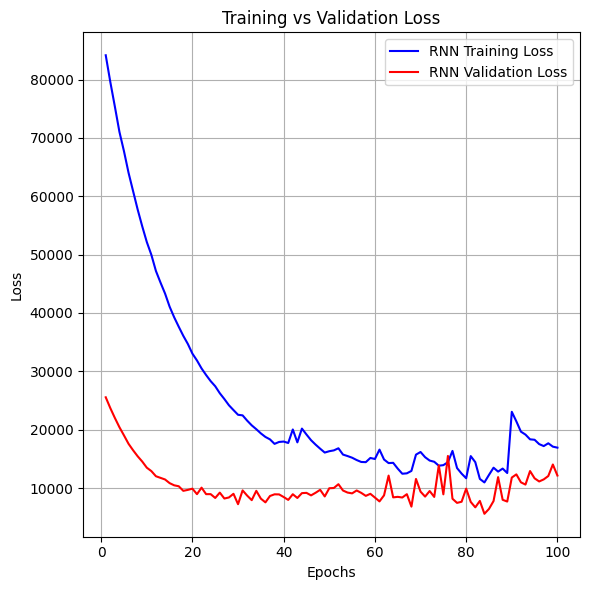

In [26]:
plot_loss_comparison(epochs, rnnnet_train_loss_array, rnnnet_val_loss_array, "RNN Training Loss", "RNN Validation Loss", "Training vs Validation Loss")

In [27]:
rnnnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = rnnnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_1472\1549511991.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


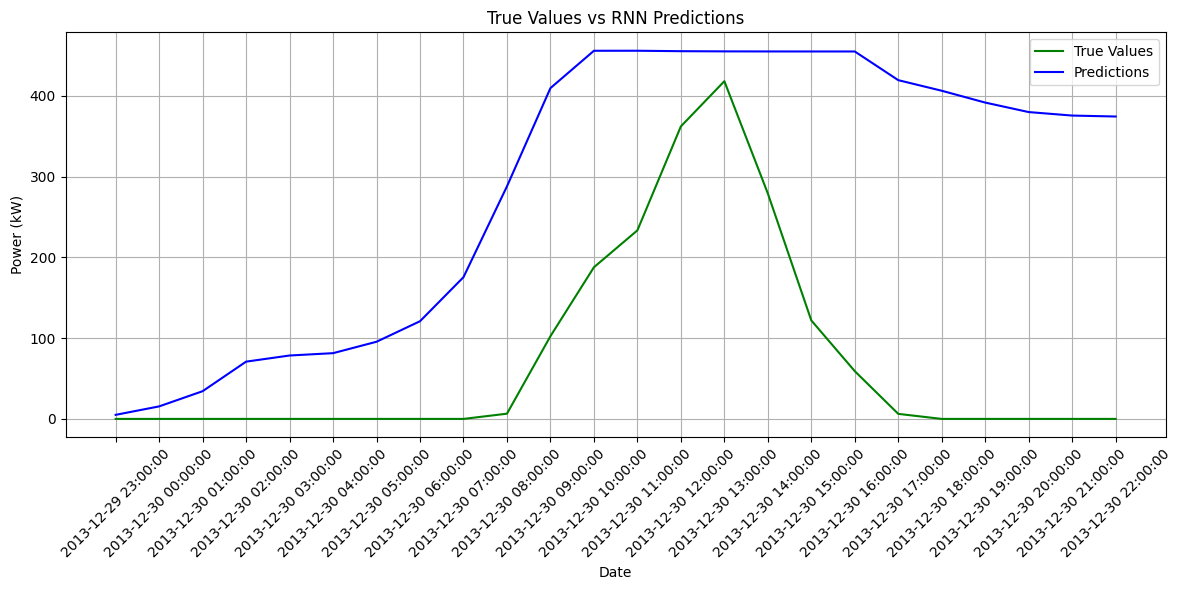

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs RNN Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
r2 = r2_score(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")
print(f'R-squared value: {r2}')

Root Mean Squared Error: 257.60299821139506
R-squared value: -3.290276220660747


## LSTM

In [30]:
class LSTMNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, (h_t, c_t) = self.lstm(x)
        out = self.fc(x_[:, -1, :])
        return out

In [31]:
lstmnet = LSTMNet(input_size, hidden_size, num_classes).to(device)
lstmnet_optimizer = torch.optim.Adam(lstmnet.parameters(), lr = learning_rate)

In [32]:
total_lstmnet_parameters = count_parameters(lstmnet)

In [33]:
lstmnet_train_loss_array = []
lstmnet_val_loss_array = []

In [34]:
lstmnet_start_time = time.time()
train_and_validate(epochs, device, lstmnet, train_loader, val_loader, criterion, lstmnet_optimizer, lstmnet_train_loss_array, lstmnet_val_loss_array)
lstmnet_end_time = time.time()
lstmnet_total_training_time = lstmnet_end_time - lstmnet_start_time
lstmnet_avg_training_time_per_epoch = lstmnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 84213.7653266059 | Validation Loss: 25350.007110595703
Epoch no.: 2 | Training Loss: 78668.31545681423 | Validation Loss: 23411.89356994629
Epoch no.: 3 | Training Loss: 74416.50179036458 | Validation Loss: 21620.487258911133
Epoch no.: 4 | Training Loss: 70754.12771267361 | Validation Loss: 20187.839385986328
Epoch no.: 5 | Training Loss: 66554.52642144097 | Validation Loss: 18292.827682495117
Epoch no.: 6 | Training Loss: 63003.001763237844 | Validation Loss: 16629.820068359375
Epoch no.: 7 | Training Loss: 59380.72425672743 | Validation Loss: 15224.524429321289
Epoch no.: 8 | Training Loss: 56217.678059895836 | Validation Loss: 14018.83512878418
Epoch no.: 9 | Training Loss: 52761.43317328559 | Validation Loss: 12985.396255493164
Epoch no.: 10 | Training Loss: 49652.76087782118 | Validation Loss: 11714.06608581543
Epoch no.: 11 | Training Loss: 47008.67472330729 | Validation Loss: 10651.174919128418
Epoch no.: 12 | Training Loss: 44613.210150824656 | Va

In [35]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     LSTM: {total_lstmnet_parameters}")
print()
print(f"Total Training Time:     LSTM: {lstmnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     LSTM: {lstmnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     LSTM: 41301

Total Training Time:     LSTM: 83.92s

Average Training Time Per Epoch:     LSTM: 0.84s
------------------------------------------------------------


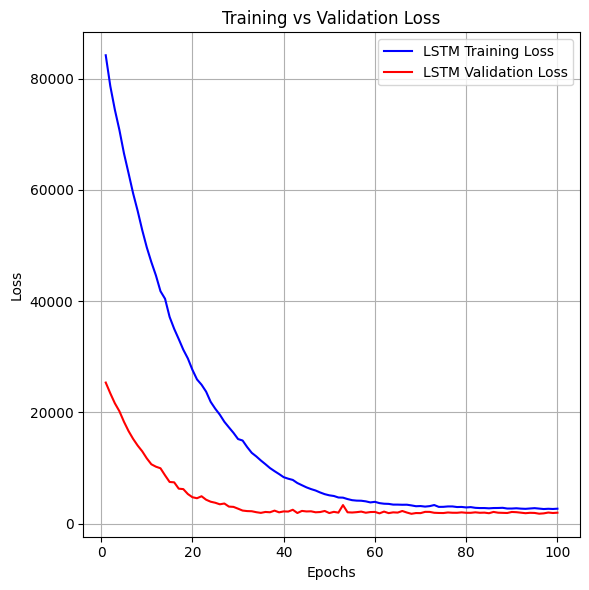

In [36]:
plot_loss_comparison(epochs, lstmnet_train_loss_array, lstmnet_val_loss_array, "LSTM Training Loss", "LSTM Validation Loss", "Training vs Validation Loss")

In [37]:
lstmnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = lstmnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_1472\22171312.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


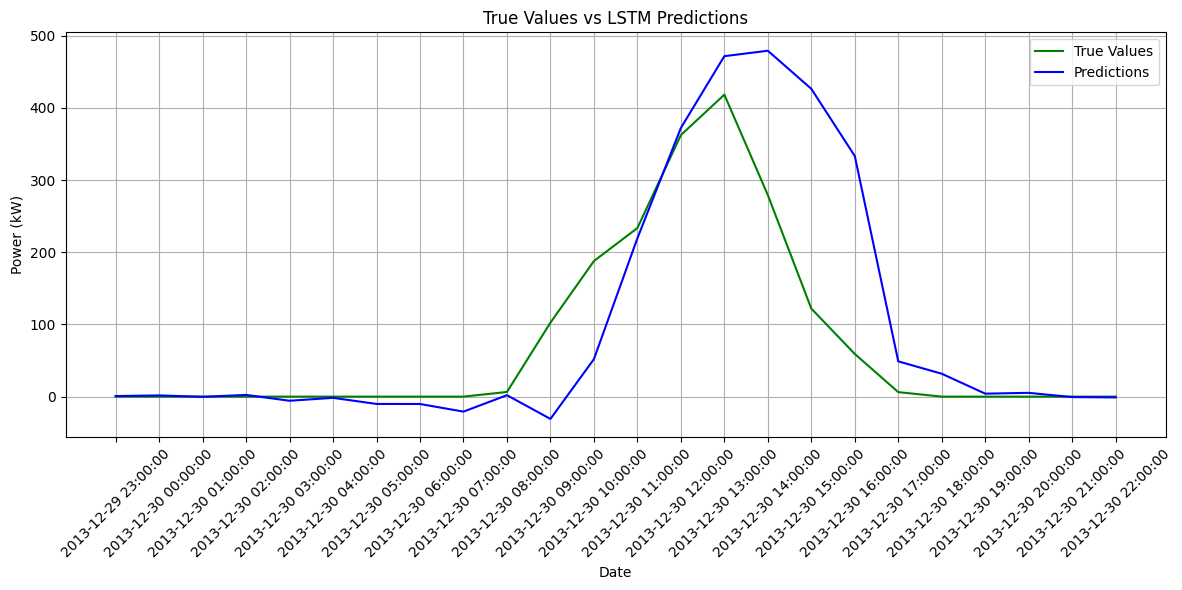

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
r2 = r2_score(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")
print(f'R-squared value: {r2}')

Root Mean Squared Error: 102.18921061259354
R-squared value: 0.32486044789067614


## GRU 

In [50]:
class GRUNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, h = self.gru(x)
        out = self.fc(x_[:, -1, :])
        return out

In [51]:
grunet = LSTMNet(input_size, hidden_size, num_classes).to(device)
grunet_optimizer = torch.optim.Adam(grunet.parameters(), lr = learning_rate)

In [52]:
total_grunet_parameters = count_parameters(grunet)

In [53]:
grunet_train_loss_array = []
grunet_val_loss_array = []

In [54]:
grunet_start_time = time.time()
train_and_validate(epochs, device, grunet, train_loader, val_loader, criterion, grunet_optimizer, grunet_train_loss_array, grunet_val_loss_array)
grunet_end_time = time.time()
grunet_total_training_time = grunet_end_time - grunet_start_time
grunet_avg_training_time_per_epoch = grunet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 84256.99934895833 | Validation Loss: 25306.356811523438
Epoch no.: 2 | Training Loss: 78955.57869466145 | Validation Loss: 23262.7313079834
Epoch no.: 3 | Training Loss: 74204.35774739583 | Validation Loss: 21508.192916870117
Epoch no.: 4 | Training Loss: 70153.5155436198 | Validation Loss: 19970.931030273438
Epoch no.: 5 | Training Loss: 66672.68433973525 | Validation Loss: 18318.645263671875
Epoch no.: 6 | Training Loss: 62624.31781684028 | Validation Loss: 16764.680221557617
Epoch no.: 7 | Training Loss: 59282.64538574219 | Validation Loss: 14848.945297241211
Epoch no.: 8 | Training Loss: 55179.36503092448 | Validation Loss: 13772.415992736816
Epoch no.: 9 | Training Loss: 52371.18505859375 | Validation Loss: 12535.517265319824
Epoch no.: 10 | Training Loss: 49605.31679958767 | Validation Loss: 11478.937522888184
Epoch no.: 11 | Training Loss: 46881.69957139757 | Validation Loss: 10535.900131225586
Epoch no.: 12 | Training Loss: 44267.134521484375 | Val

In [55]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     GRU: {total_grunet_parameters}")
print()
print(f"Total Training Time:     GRU: {grunet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     GRU: {grunet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     GRU: 41301

Total Training Time:     GRU: 80.73s

Average Training Time Per Epoch:     GRU: 0.81s
------------------------------------------------------------


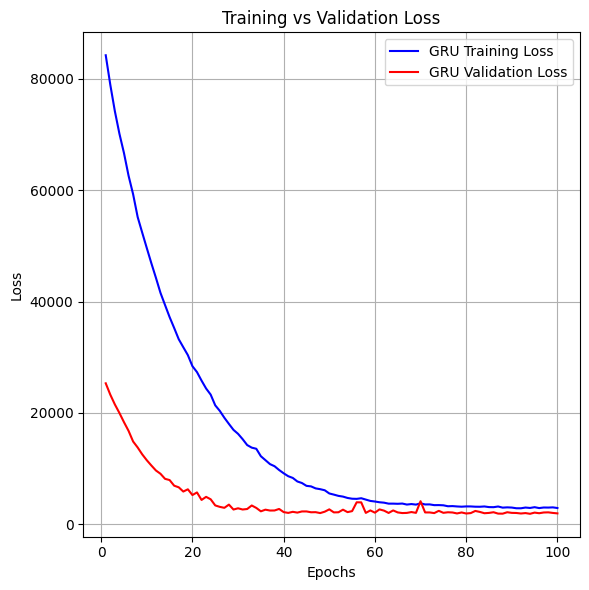

In [56]:
plot_loss_comparison(epochs, grunet_train_loss_array, grunet_val_loss_array, "GRU Training Loss", "GRU Validation Loss", "Training vs Validation Loss")

In [57]:
grunet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = grunet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_1472\1542476720.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


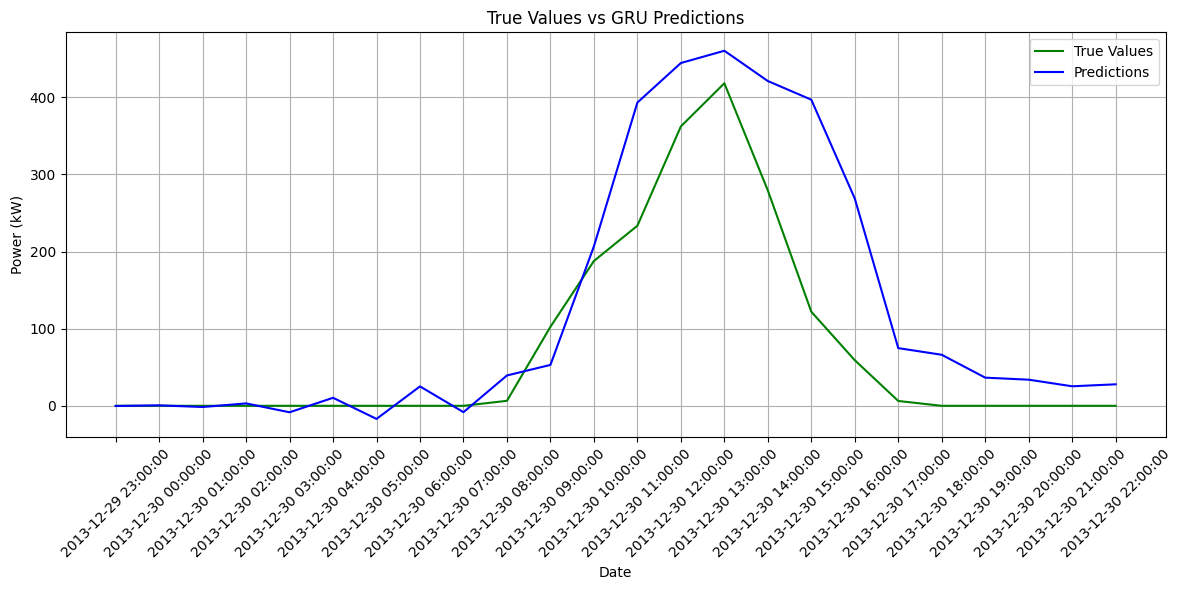

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs GRU Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
r2 = r2_score(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")
print(f'R-squared value: {r2}')

Root Mean Squared Error: 89.38249531507833
R-squared value: 0.48347848516160497
